### Final stages of data preprocessing before training

The goal is to consolidate the processed twitter data and the MSFT stock data. For each date, collect the last ten days of stock data, and the last five days of twitter data (for each day, average tweet volume, average sentiment). Also determine if the stock price went up (1) or down (0) and use as class/label.  

In [205]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import base64
from datetime import datetime, timedelta

%matplotlib inline

In [206]:
msft_stock = pd.read_csv('MSFT.csv')
msft_stock.head()
msft_stock.shape

(241, 7)

In [207]:
#convert to datetime
msft_stock['Date'] = pd.to_datetime(msft_stock.Date)
# msft_stock['Changed_Date'] = msft_stock['Date'].dt.strftime('%m/%d/%Y')
msft_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-27,47.230000,48.130001,47.220001,48.029999,43.880901,59248200
1,2015-04-28,47.779999,49.209999,47.700001,49.160000,44.913280,60730800
2,2015-04-29,48.720001,49.310001,48.500000,49.060001,44.821926,47804600
3,2015-04-30,48.700001,49.540001,48.599998,48.639999,44.438210,64725500
4,2015-05-01,48.580002,48.880001,48.400002,48.660000,44.456478,38937300


In [208]:
msft_twitter = pd.read_csv('microsoft_stock.csv')
msft_twitter['date'] = pd.to_datetime(msft_twitter.date)
msft_twitter.head()

,date,followers,sentiment,location
0,2015-04-27,307,0.6892,Washington
1,2015-04-27,272,0.0000,Washington
2,2015-04-27,211,0.0000,Washington
3,2015-04-27,1107,0.0000,Washington
4,2015-04-27,959,0.0000,Washington


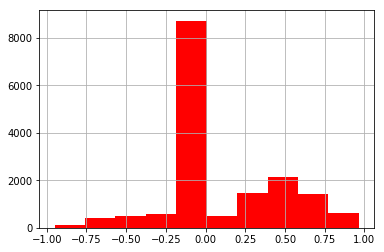

In [214]:
plot = msft_twitter["sentiment"].hist(color='r')
fig = plot.get_figure()
fig.savefig("msft_sentiment.png")

In [215]:
#group tweets by date and average followers and sentiment for given day
grouped_tweets = msft_twitter.groupby("date", as_index=False).mean()
grouped_tweets['followers'].head()
#print(grouped_tweets.index)

0     744.965517
1    1548.950000
2    6545.855932
3    1411.784946
4    1416.228916
Name: followers, dtype: float64

In [219]:
#Iterate through dataframes and assemble training data

#training array
# stock_change_1,sent_1,foll_1,...foll_2,foll_3,foll_4,foll_5
stock_tweet = []
stock = []
#class array
#delta (0 or 1)
close_delta = []

# iterate through msft stock array
for day in range(6,len(msft_stock['Date'])-1):
    training_entry = []
    stock_entry = []
    label_entry = 0
    try:
        # iterate through previous 5 stock dates
        for i in range(day-5,day):
            #print(i)
            #calculate stock change percent
            stock_change = (msft_stock['Adj Close'][i]-msft_stock['Adj Close'][i-1])/msft_stock['Adj Close'][i-1]
            #add 4 days worth of stock change. 5th day goes into prediction class.
            stock_entry.append(stock_change)
            training_entry.append(stock_change)
            # extract relevant row from from grouped tweet df
            tweet_row = grouped_tweets.loc[grouped_tweets['date'] == msft_stock['Date'][i]]
            training_entry.append(float(tweet_row['sentiment']))
            training_entry.append(float(tweet_row['followers']))
        label_entry = (msft_stock['Adj Close'][day]-msft_stock['Adj Close'][day-1])/msft_stock['Adj Close'][day-1]
        stock_tweet.append(training_entry)
        #print(len(training_entry))
        stock.append(stock_entry)
        close_delta.append(label_entry)
#         print(training_entry)
#         print(label_entry)
#         print("\n")
    except:
        pass
    #print(day)
#msft_stock['Date'][4]-msft_stock['Date'][0]
#timedelta(days=5)

In [220]:
print(len(stock_tweet))
print(len(stock))
print(len(close_delta))

219
219
219


### Write training dataframe to csv

In [221]:
full_data = []
for i in range (0,len(stock_tweet)):
    row = stock_tweet[i]
    row.append(close_delta[i])
    #print(len(row))
    full_data.append(row)
  
full_training = pd.DataFrame(full_data, columns = ['day1_close','day1_sentiment','day1_followers','day2_close','day2_sentiment','day2_followers','day3_close','day3_sentiment','day3_followers','day4_close','day4_sentiment','day4_followers','day5_close','day5_sentiment','day5_followers','day6_delta'])
full_training.to_csv('full_training_data.csv', index="False", sep=',', encoding='utf-8')
full_training.head()


,day1_close,day1_sentiment,day1_followers,day2_close,day2_sentiment,day2_followers,day3_close,day3_sentiment,day3_followers,day4_close,day4_sentiment,day4_followers,day5_close,day5_sentiment,day5_followers,day6_delta
0,0.023527,-0.019865,1548.950000,-0.002034,0.174986,6545.855932,-0.008561,0.126985,1411.784946,0.000411,0.198365,1416.228916,-0.008631,0.124655,2960.428571,-0.013267
1,-0.002034,0.174986,6545.855932,-0.008561,0.126985,1411.784946,0.000411,0.198365,1416.228916,-0.008631,0.124655,2960.428571,-0.013267,0.101424,1439.433735,-0.027731
2,-0.008561,0.126985,1411.784946,0.000411,0.198365,1416.228916,-0.008631,0.124655,2960.428571,-0.013267,0.101424,1439.433735,-0.027731,0.071216,3489.701493,0.009075
3,0.000411,0.198365,1416.228916,-0.008631,0.124655,2960.428571,-0.013267,0.101424,1439.433735,-0.027731,0.071216,3489.701493,0.009075,0.062804,5839.215686,0.022484
4,-0.008631,0.124655,2960.428571,-0.013267,0.101424,1439.433735,-0.027731,0.071216,3489.701493,0.009075,0.062804,5839.215686,0.022484,0.048287,2356.814815,-0.007958


## Training binary classification 
#### 15 element feature vector with 5 previous days of stock price delta, followers, and sentiment

In [222]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score #accuracy scoring

##### Training with full 15 element feature vector

In [223]:
#create binary classification of delta (1 = pos, 0 = neg)
binary_delta = []

for i in close_delta:
    if i >= 0:
        binary_delta.append(1)
    else:
        binary_delta.append(0)
print(len(binary_delta))

219


In [228]:
#create binary classification of delta (1 = pos, 0 = neg)
binary_delta = []

for i in close_delta:
    if i >= 0:
        binary_delta.append(1)
    else:
        binary_delta.append(0)

#numpy array version of data
X = np.array(stock_tweet)
y = np.array(binary_delta)

#split into training/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=26)

print("Performance with Twitter data and Stocks")
for n in range (1,10):
    #model training svm approach
    # clf = SVC(kernel="rbf")
    # clf = LinearSVC(max_iter=10000,random_state=0, tol=1e-5,C=0.2)
    print("neighbors: " + str(n))
    clf = KNeighborsClassifier(n_neighbors=n,weights='distance',leaf_size=15)
    # clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
    #                          algorithm="SAMME",
    #                          n_estimators=200)
    #linear kernel train-0.54/test-0.68

    #clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    
    # print("Train Acc: " + str(clf.score(X_train,y_train)))
    print("10F CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("\n")

Performance with Twitter data and Stocks
neighbors: 1
10F CV Accuracy: 0.55 (+/- 0.12)


neighbors: 2
10F CV Accuracy: 0.55 (+/- 0.12)


neighbors: 3
10F CV Accuracy: 0.60 (+/- 0.15)


neighbors: 4
10F CV Accuracy: 0.56 (+/- 0.15)


neighbors: 5
10F CV Accuracy: 0.60 (+/- 0.26)


neighbors: 6
10F CV Accuracy: 0.57 (+/- 0.20)


neighbors: 7
10F CV Accuracy: 0.56 (+/- 0.23)


neighbors: 8
10F CV Accuracy: 0.54 (+/- 0.24)


neighbors: 9
10F CV Accuracy: 0.55 (+/- 0.23)




##### Training with 5 element feature vector (stock only)

In [225]:
#numpy array version of data
X = np.array(stock)
y = np.array(binary_delta)

#split into training/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22)

#model training svm approach
# clf = SVC(kernel="rbf")
clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Performance with Stocks")
# print("Accuracy: " + str(clf.score(X_train,y_train)))
print("10F CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Performance with Stocks
10F CV Accuracy: 0.45 (+/- 0.26)


## Training close delta prediction
#### 15 element feature vector with 5 previous days of stock price delta, followers, and sentiment

In [226]:
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge

In [227]:
#numpy array version of data
X = np.array(stock_tweet)
y = np.array(close_delta)

#split into training/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

#model training Ridge Regression approach
# clf = linear_model.Lasso(alpha=0.1)
# clf = ElasticNet(random_state=0)
for a in range (0,11):
    clf = Ridge(alpha=a)
    #clf = linear_model.Lasso(alpha=(a/10))
    # clf = ElasticNet(random_state=0)

    clf.fit(X_train, y_train)
    print("alpha: " + str(a))
    print("Score: " + str(clf.score(X_test, y_test)))
    print("\n")


alpha: 0
Score: 1.0


alpha: 1
Score: 0.0578309120620284


alpha: 2
Score: 0.021718210964872364


alpha: 3
Score: 0.008883544047841196


alpha: 4
Score: 0.002264142104735356


alpha: 5
Score: -0.0017829473709276564


alpha: 6
Score: -0.004515566989832243


alpha: 7
Score: -0.006485490513349346


alpha: 8
Score: -0.007973277151808178


alpha: 9
Score: -0.009136795388405838


alpha: 10
Score: -0.010071723953851697


